# First Models on the MITBIH Database

In [322]:
import wfdb
import scipy as sci
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.fftpack
from scipy.signal import medfilt
#%matplotlib inline

## 1. Data source

In [344]:
# List of all patients

patients_id = []

with open('mitbih/file_list.txt', 'r') as files:
    for f in files:
        record_nb = str(f[:3])
        patients_id.append(int(f[:3]))
        
df_patient = pd.DataFrame(index=patients_id)

In [345]:
# Create all 10 sec windows

# size in seconds of the truncated windows
windows_size_seconds = 10

# list of all windows and their corresponding annotations
all_windows = []
all_annot = []

# read MITBIH database and generate all 10sec samples
with open('mitbih/file_list.txt', 'r') as files:
    for f in files:
        f_records = []
        f_annot = []
        record_nb = str(f[:3])
        record = wfdb.rdrecord('mitbih/' + record_nb)
        sig_len = record.sig_len
        annotation = wfdb.rdann('mitbih/' + record_nb, 'atr')
        windows_size = windows_size_seconds * record.fs
        #windows_nb = sig_len // windows_size
        for w in range(0, sig_len-windows_size, windows_size):
            f_records.append(wfdb.rdrecord('mitbih/' + record_nb, sampfrom=w, sampto=w+windows_size))
            temp_annot = wfdb.rdann('mitbih/' + record_nb, 'atr', sampfrom=w, sampto=w+windows_size)
            # move annot to 0: -1 because annotations started at 1 (python array start at 0)
            temp_annot.sample -= (w + 1)
            f_annot.append(temp_annot)
        all_windows.append(f_records)
        all_annot.append(f_annot)
        print(record_nb)

100
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
200
201
202
203
205
207
208
209
210
212
213
214
215
217
219
220
221
222
223
228
230
231
232
233
234


In [346]:
# Number of generated samples
print('nb of patients:', len(all_windows))
print('nb of windows per patient:', len(all_windows[0]))

nb of patients: 48
nb of windows per patient: 180


In [347]:
def plot_single_window(index, copy=True):
    patient = int(str(index)[:3])
    window = int(str(index)[3:7])
    record = all_windows[patients_id.index(patient)][window]
    annotation = all_annot[patients_id.index(patient)][window]
    wfdb.plot_items(signal = record.p_signal, 
                ann_samp = [annotation.sample, annotation.sample],
                ann_sym = [annotation.symbol, annotation.symbol],
                title = 'Record %s from MIT-BIH Arrhythmia Database' % record.record_name,
                fs = record.fs,
                time_units = 'seconds',
                figsize = (16,7)
                )

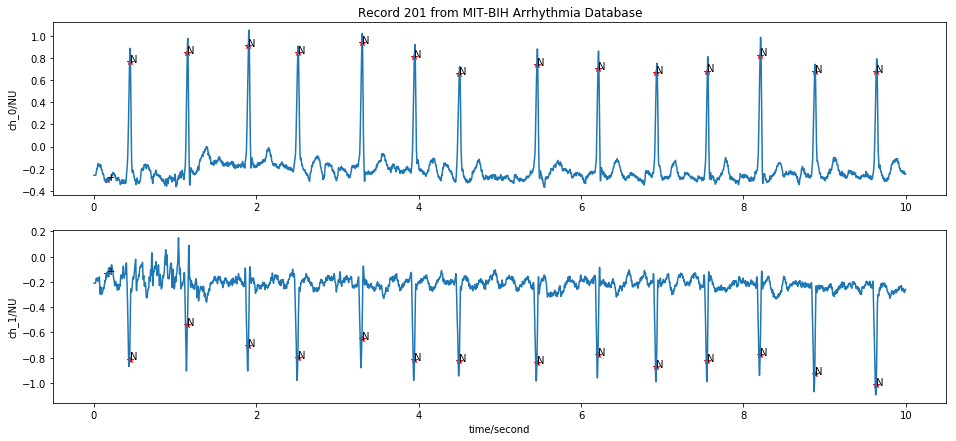

In [348]:
plot_single_window(201_0)

# 2. Pre-processing

#### Remove baseline of the signal

In [349]:
def remove_baseline(kernel_size, channel):
    for pat in range(len(all_windows)):
        for w in range(len(all_windows[pat])):
            baseline = medfilt(all_windows[pat][w].p_signal[:, channel], kernel_size)
            all_windows[pat][w].p_signal[:, channel] = all_windows[pat][w].p_signal[:, channel] - baseline

In [350]:
remove_baseline(kernel_size=21, channel=0)

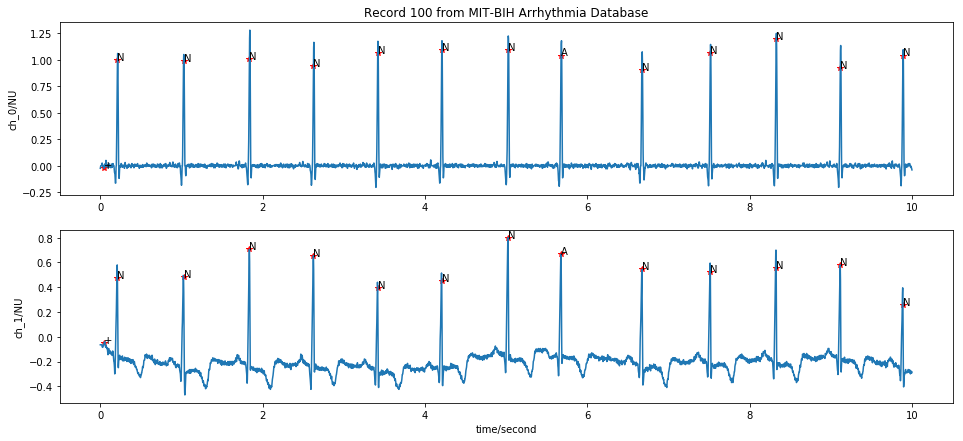

In [378]:
plot_single_window(100_0)

# 3. Features

In [432]:
import pywt
import scipy.stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#### Extraction

In [434]:
# Build the dataset
df_windows = pd.DataFrame()

for pat in range(len(all_windows)):
    for w in range(len(all_windows[pat])):
        index = str(patients_id[pat]) + '_' + str(w)
        record = all_windows[pat][w]
        signal = record.p_signal[:, 0]
        annotation = all_annot[pat][w]
        sig_at_annot = signal[annotation.sample]
        dist_btw_annot = (annotation.sample[1:] - annotation.sample[:-1]) / record.fs
        beats_isolated = [signal[max(0,ann-40):min(ann+40, 3600)] for ann in annotation.sample]
        
        # ID feature
        df_windows.loc[index, 'ID_patient'] = int(index[:3])
        df_windows.loc[index, 'ID_sample'] = int(index[4:7])
        
        # Raw signal
        #df_windows.loc[index, 'Signal'] = signal 
        
        # Basic stats 
        df_windows.loc[index, 'Max'] = np.max(signal)
        df_windows.loc[index, 'Min'] = np.min(signal)
        df_windows.loc[index, 'Mean'] = np.mean(signal)
        df_windows.loc[index, 'Percent10_peak'] = np.percentile(sig_at_annot, 10)
        df_windows.loc[index, 'Mean_peak'] = np.mean(sig_at_annot)
        df_windows.loc[index, 'Percent90_peak'] = np.percentile(sig_at_annot, 90)
        
        # Wavelets
        
        # High order stats (HOS)
        skew = np.array([scipy.stats.skew(beat, 0, True) for beat in beats_isolated])
        df_windows.loc[index, 'Min_skew'] = np.min(skew)
        df_windows.loc[index, 'Mean_skew'] = np.mean(skew)
        df_windows.loc[index, 'Max_skew'] = np.max(skew)
        df_windows.loc[index, 'Min_skew_r'] = df_windows.loc[index, 'Min_skew'] / df_windows.loc[index, 'Mean_skew']
        df_windows.loc[index, 'Max_skew_r'] = df_windows.loc[index, 'Max_skew'] / df_windows.loc[index, 'Mean_skew']

        # Peak to Peak
        df_windows.loc[index, 'Mean_Peak2Peak'] = np.mean(dist_btw_annot)
        df_windows.loc[index, 'Max_Peak2Peak'] = np.max(dist_btw_annot)
        df_windows.loc[index, 'Min_Peak2Peak'] = np.min(dist_btw_annot)
        df_windows.loc[index, 'Outliers_Peak2Peak_1'] = int(max(dist_btw_annot > np.mean(dist_btw_annot) + 2*np.std(dist_btw_annot)))
        df_windows.loc[index, 'Outliers_Peak2Peak_2'] = max(dist_btw_annot - np.mean(dist_btw_annot))
        # Peak to Pea ratios
        df_windows.loc[index, 'Max_Peak2Peak_r'] = np.max(dist_btw_annot) / df_windows.loc[index, 'Mean_Peak2Peak']
        df_windows.loc[index, 'Min_Peak2Peak_r'] = np.min(dist_btw_annot) / df_windows.loc[index, 'Mean_Peak2Peak']
        df_windows.loc[index, 'Outliers_Peak2Peak_1_r'] = int(max(dist_btw_annot > np.mean(dist_btw_annot) + 2*np.std(dist_btw_annot)) / df_windows.loc[index, 'Mean_Peak2Peak'])
        df_windows.loc[index, 'Outliers_Peak2Peak_2_r'] = max(dist_btw_annot - np.mean(dist_btw_annot)) / df_windows.loc[index, 'Mean_Peak2Peak']
        
        # Other
        df_windows.loc[index, 'Age'] = record.comments[0][:2]
        df_windows.loc[index, 'Gender'] = record.comments[0][3]
        
        # Annotations
        #df_windows.loc[index, 'N'] = annotation.symbol.count('N')
        #df_windows.loc[index, 'NotN'] = annotation.ann_len - annotation.symbol.count('N')
        #df_windows.loc[index, 'V'] = annotation.symbol.count('V')
        #df_windows.loc[index, 'NotV'] = annotation.ann_len - annotation.symbol.count('V')
        #df_windows.loc[index, 'V_ratio'] = df_windows.loc[index, 'V'] / (df_windows.loc[index, 'V'] + df_windows.loc[index, 'NotV']) 
        #df_windows.loc[index, 'N_ratio'] = df_windows.loc[index, 'N'] / (df_windows.loc[index, 'N'] + df_windows.loc[index, 'NotN']) 
        df_windows.loc[index, 'PVC'] = int(annotation.symbol.count('V') > 0)

print("Done")

Done


In [435]:
df_windows.head(10)

,ID_patient,ID_sample,Max,Min,Mean,Percent10_peak,Mean_peak,Percent90_peak,Min_skew,Mean_skew,...,Min_Peak2Peak,Outliers_Peak2Peak_1,Outliers_Peak2Peak_2,Max_Peak2Peak_r,Min_Peak2Peak_r,Outliers_Peak2Peak_1_r,Outliers_Peak2Peak_2_r,Age,Gender,PVC
100_0,100.0,0.0,1.280,-0.205,0.020242,0.9110,0.952143,1.0935,0.870155,2.815385,...,0.163889,0.0,0.237607,1.313947,0.216544,0.0,0.313947,69,M,0.0
100_1,100.0,1.0,1.245,-0.210,0.018778,0.8790,0.999167,1.0975,2.732268,2.929108,...,0.786111,1.0,0.050253,1.061344,0.959618,1.0,0.061344,69,M,0.0
100_2,100.0,2.0,1.215,-0.240,0.018481,0.8705,1.020000,1.1095,2.618532,2.922565,...,0.775000,0.0,0.050253,1.062188,0.959063,0.0,0.062188,69,M,0.0
100_3,100.0,3.0,1.240,-0.235,0.018163,0.9145,1.047083,1.1325,2.834988,2.942158,...,0.777778,1.0,0.063131,1.077232,0.951498,1.0,0.077232,69,M,0.0
100_4,100.0,4.0,1.250,-0.225,0.019624,0.9110,1.012692,1.0690,2.479244,2.837098,...,0.780556,0.0,0.025926,1.031782,0.956867,0.0,0.031782,69,M,0.0
100_5,100.0,5.0,1.265,-0.230,0.017783,0.9205,0.972917,1.0625,2.756032,2.915307,...,0.780556,0.0,0.048485,1.060075,0.967146,0.0,0.060075,69,M,0.0
100_6,100.0,6.0,1.255,-0.220,0.019201,0.8750,1.009231,1.1380,2.328108,2.897453,...,0.772222,0.0,0.038889,1.048443,0.961938,0.0,0.048443,69,M,0.0
100_7,100.0,7.0,1.260,-0.230,0.018590,1.0065,1.041250,1.0845,2.787915,2.882279,...,0.783333,0.0,0.039646,1.048427,0.956817,0.0,0.048427,69,M,0.0
100_8,100.0,8.0,1.310,-0.245,0.018533,0.8725,1.016250,1.1345,2.694295,2.896699,...,0.777778,1.0,0.047727,1.058879,0.959502,1.0,0.058879,69,M,0.0
100_9,100.0,9.0,1.340,-0.240,0.019919,0.9185,1.064583,1.1735,2.636351,2.879878,...,0.766667,0.0,0.042929,1.053009,0.946679,0.0,0.053009,69,M,0.0


#### Convert categorical variables into numbers

In [436]:
df_windows['Gender'].replace(['M', 'F'], [0, 1], inplace=True)

In [437]:
df_windows.head(10)

,ID_patient,ID_sample,Max,Min,Mean,Percent10_peak,Mean_peak,Percent90_peak,Min_skew,Mean_skew,...,Min_Peak2Peak,Outliers_Peak2Peak_1,Outliers_Peak2Peak_2,Max_Peak2Peak_r,Min_Peak2Peak_r,Outliers_Peak2Peak_1_r,Outliers_Peak2Peak_2_r,Age,Gender,PVC
100_0,100.0,0.0,1.280,-0.205,0.020242,0.9110,0.952143,1.0935,0.870155,2.815385,...,0.163889,0.0,0.237607,1.313947,0.216544,0.0,0.313947,69,0,0.0
100_1,100.0,1.0,1.245,-0.210,0.018778,0.8790,0.999167,1.0975,2.732268,2.929108,...,0.786111,1.0,0.050253,1.061344,0.959618,1.0,0.061344,69,0,0.0
100_2,100.0,2.0,1.215,-0.240,0.018481,0.8705,1.020000,1.1095,2.618532,2.922565,...,0.775000,0.0,0.050253,1.062188,0.959063,0.0,0.062188,69,0,0.0
100_3,100.0,3.0,1.240,-0.235,0.018163,0.9145,1.047083,1.1325,2.834988,2.942158,...,0.777778,1.0,0.063131,1.077232,0.951498,1.0,0.077232,69,0,0.0
100_4,100.0,4.0,1.250,-0.225,0.019624,0.9110,1.012692,1.0690,2.479244,2.837098,...,0.780556,0.0,0.025926,1.031782,0.956867,0.0,0.031782,69,0,0.0
100_5,100.0,5.0,1.265,-0.230,0.017783,0.9205,0.972917,1.0625,2.756032,2.915307,...,0.780556,0.0,0.048485,1.060075,0.967146,0.0,0.060075,69,0,0.0
100_6,100.0,6.0,1.255,-0.220,0.019201,0.8750,1.009231,1.1380,2.328108,2.897453,...,0.772222,0.0,0.038889,1.048443,0.961938,0.0,0.048443,69,0,0.0
100_7,100.0,7.0,1.260,-0.230,0.018590,1.0065,1.041250,1.0845,2.787915,2.882279,...,0.783333,0.0,0.039646,1.048427,0.956817,0.0,0.048427,69,0,0.0
100_8,100.0,8.0,1.310,-0.245,0.018533,0.8725,1.016250,1.1345,2.694295,2.896699,...,0.777778,1.0,0.047727,1.058879,0.959502,1.0,0.058879,69,0,0.0
100_9,100.0,9.0,1.340,-0.240,0.019919,0.9185,1.064583,1.1735,2.636351,2.879878,...,0.766667,0.0,0.042929,1.053009,0.946679,0.0,0.053009,69,0,0.0


In [438]:
df_windows.describe()

,ID_patient,ID_sample,Max,Min,Mean,Percent10_peak,Mean_peak,Percent90_peak,Min_skew,Mean_skew,...,Max_Peak2Peak,Min_Peak2Peak,Outliers_Peak2Peak_1,Outliers_Peak2Peak_2,Max_Peak2Peak_r,Min_Peak2Peak_r,Outliers_Peak2Peak_1_r,Outliers_Peak2Peak_2_r,Gender,PVC
count,8640.000000,8640.00000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,...,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000
mean,166.229167,89.50000,1.091006,-0.408907,0.014933,0.494273,0.687356,0.854092,1.108800,2.148653,...,0.974999,0.644793,0.261343,0.169904,1.221622,0.785449,0.245833,0.221622,0.458333,0.275694
std,53.064058,51.96373,0.523122,0.300002,0.010588,0.508495,0.477260,0.510076,1.665997,1.136323,...,0.298956,0.252747,0.439392,0.233928,0.271355,0.218809,0.446443,0.271355,0.498290,0.446889
min,100.000000,0.00000,0.040000,-2.270000,-0.017418,-1.073000,-0.600000,-0.515000,-4.020425,-3.113346,...,0.300000,0.016667,0.000000,0.004365,1.006429,0.023353,0.000000,0.006429,0.000000,0.000000
25%,112.750000,44.75000,0.685000,-0.540000,0.007384,0.142000,0.422299,0.523000,-0.002432,1.829596,...,0.788889,0.461111,0.000000,0.038889,1.046229,0.640249,0.000000,0.046229,0.000000,0.000000
50%,200.500000,89.50000,1.000000,-0.320000,0.013133,0.442000,0.625486,0.778000,1.599184,2.420909,...,0.916667,0.663889,0.000000,0.078308,1.094391,0.907843,0.000000,0.094391,0.000000,0.000000
75%,215.500000,134.25000,1.435000,-0.200000,0.021290,0.842500,1.009706,1.197625,2.503586,2.826976,...,1.091667,0.816667,1.000000,0.231313,1.334178,0.955782,0.000000,0.334178,1.000000,1.000000
max,234.000000,179.00000,2.630000,-0.035000,0.053646,1.879000,2.013889,2.222000,4.348667,4.602724,...,5.872222,2.327778,1.000000,4.009444,4.261658,0.993783,3.000000,3.261658,1.000000,1.000000


#### patients with(out) PVC

In [439]:
df_windows[['ID_patient', 'PVC']].groupby('ID_patient').sum() > 0;

#### Train/Test split

In [440]:
def naive_split():
    x = df_windows.drop(['PVC', 'ID_patient', 'ID_sample'], axis=1).values
    y = df_windows['PVC'].values
    print('X shape:', X.shape)
    print('Y shape:', Y.shape)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)
    return x_train, x_test, y_train, y_test
    
def chazal_split(nb_test_patients=10):
    np.random.seed(100)
    # permute patients id and then split at nb_test_patient 
    temp = np.random.choice(patients_id, len(patients_id), replace=False)
    df_test = pd.DataFrame()
    df_train = pd.DataFrame()
    for pat in temp[0:nb_test_patients]:
        df_pat = df_windows[df_windows['ID_patient'] == pat]
        df_test = pd.concat([df_test, df_pat])
    for pat in temp[nb_test_patients:]:
        df_pat = df_windows[df_windows['ID_patient'] == pat]
        df_train = pd.concat([df_train, df_pat])
    x_train = df_train.drop(['PVC', 'ID_patient', 'ID_sample'], axis=1)
    x_test = df_test.drop(['PVC', 'ID_patient', 'ID_sample'], axis=1)
    y_train = df_train['PVC']
    y_test = df_test['PVC']
    return x_train, x_test, y_train, y_test

def balanced_chazal_split():
    noPVC_patients = [101, 103, 112, 113, 115, 117, 122, 212, 220, 222, 232]
    PVC_patients = [100, 102, 104, 105, 106, 107, 108, 109, 111, 114, 116, 118, 
                    119, 121, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 
                    210, 213, 214, 215, 217, 219, 221, 223, 228, 230, 231, 233, 
                    234]
    n = len(noPVC_patients)
    temp = np.random.choice(PVC_patients, n, replace=False)
    pass
    
#x_train, x_test, y_train, y_test = naive_split()
x_train, x_test, y_train, y_test = chazal_split()

In [462]:
# Sanity check 
print('Check dimensions:')
print('(x_train)', x_train.shape) 
print('(x_test)', x_test.shape)
print('(y_train)', y_train.shape)
print('(y_test)', y_test.shape)
print('Train/Test %.0f / %.0f' % (100 * x_train.shape[0] / (x_train.shape[0] + x_test.shape[0]), 
                             100 * x_test.shape[0] / (x_train.shape[0] + x_test.shape[0])))

Check dimensions:
(x_train) (6840, 22)
(x_test) (1800, 22)
(y_train) (6840,)
(y_test) (1800,)
Train/Test 79 / 21


#### Normalization

In [463]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# 4. Learning Model

In [480]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

#### Baseline on the (unbalanced) dataset

In [465]:
# Just the ratio of PVC sample over the total nb of samples
ratio = len(df_windows[df_windows.PVC == 1]) / len(df_windows)

print('Accuracy lowest objective', 1 - ratio)

# Return .275 so we need to beat an accuracy of .725

Accuracy lowest objective 0.7243055555555555


#### Logistic Regression

In [469]:
clf_logreg = LogisticRegression(C=10)

clf_logreg.fit(x_train, y_train)
y_pred_logreg = clf_logreg.predict(x_test)

In [470]:
clf_logreg.__dict__

{'C': 10,
 'class_weight': None,
 'classes_': array([ 0.,  1.]),
 'coef_': array([[-0.65261753, -0.07077085,  1.34856062, -0.51939843, -1.92048068,
          1.46734774, -0.47327133, -0.51963772,  0.87202945, -0.293175  ,
         -0.42066327,  2.87578755, -0.25151657, -4.42077951,  0.78720705,
         -2.46587761,  1.34305774,  2.21677405, -0.45651695,  1.34305774,
          0.25037553, -0.51336275]]),
 'dual': False,
 'fit_intercept': True,
 'intercept_': array([-2.00877257]),
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_iter_': array([8], dtype=int32),
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [471]:
# Confusion matrix
ConfusionMatrix = pd.DataFrame(confusion_matrix(y_test, y_pred_logreg), 
                                columns=['Predicted 0','Predicted 1'], 
                                index=['Actual 0','Actual 1'])
ConfusionMatrix

,Predicted 0,Predicted 1
Actual 0,996,137
Actual 1,248,419


In [472]:
# Precision
print('Precision:', ConfusionMatrix.iloc[0,0] / (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,0]))

# Recall
print('Recall:', ConfusionMatrix.iloc[0,0] / (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,1]))

# Accuracy
print('Accuracy:', (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,1]) / (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,0] + ConfusionMatrix.iloc[0,1] + ConfusionMatrix.iloc[1,1]))

Precision: 0.800643086817
Recall: 0.703886925795
Accuracy: 0.786111111111


#### Logistic regression tuned by grid search

In [493]:
powers = [-5, -4, -3, -2, -1, 0, 1, 2]
C_values = [10**power for power in powers]

In [494]:
classifier = LogisticRegression()

param_grid = {'C': C_values, 
             'penalty': ['l1', 'l2']}

clf_logreg_opt = GridSearchCV(classifier,
                             param_grid,
                             scoring='roc_auc')

clf_logreg_opt.fit(x_train, y_train)
y_pred_logreg_opt = clf_logreg_opt.predict(x_test)

# Read the best parameters
c_value_opt = clf_logreg_opt.best_params_['C']
c_value_opt

0.0001

In [495]:
# Confusion matrix
ConfusionMatrix = pd.DataFrame(confusion_matrix(y_test, y_pred_logreg_opt), 
                                columns=['Predicted 0','Predicted 1'], 
                                index=['Actual 0','Actual 1'])
ConfusionMatrix

,Predicted 0,Predicted 1
Actual 0,808,325
Actual 1,35,632


In [496]:
# Precision
print('Precision:', ConfusionMatrix.iloc[0,0] / (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,0]))

# Recall
print('Recall:', ConfusionMatrix.iloc[0,0] / (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,1]))

# Accuracy
print('Accuracy:', (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,1]) / (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,0] + ConfusionMatrix.iloc[0,1] + ConfusionMatrix.iloc[1,1]))

Precision: 0.958481613286
Recall: 0.561111111111
Accuracy: 0.8


#### SVM

In [460]:
clf_svm = SVC(kernel='rbf')
# kernels can be 'linear', 'poly', 'rbf'

clf_svm.fit(x_train, y_train)
y_pred_svm = clf_svm.predict(x_test)

# Confusion matrix
ConfusionMatrix2 = pd.DataFrame(confusion_matrix(y_test, y_pred_svm), 
                                columns=['Predicted 0','Predicted 1'], 
                                index=['Actual 0','Actual 1'])
ConfusionMatrix2

,Predicted 0,Predicted 1
Actual 0,1046,87
Actual 1,121,546


In [461]:
# Precision
print('Precision:', ConfusionMatrix2.iloc[0,0] / (ConfusionMatrix2.iloc[0,0] + ConfusionMatrix2.iloc[1,0]))

# Recall
print('Recall:', ConfusionMatrix2.iloc[0,0] / (ConfusionMatrix2.iloc[0,0] + ConfusionMatrix2.iloc[1,1]))

# Accuracy
print('Accuracy:', (ConfusionMatrix2.iloc[0,0] + ConfusionMatrix2.iloc[1,1]) / (ConfusionMatrix2.iloc[0,0] + ConfusionMatrix2.iloc[1,0] + ConfusionMatrix2.iloc[0,1] + ConfusionMatrix2.iloc[1,1]))


Precision: 0.896315338475
Recall: 0.657035175879
Accuracy: 0.884444444444
